## Fruits 360 Recognition

In [2]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data'

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        print(image)

FileNotFoundError: [Errno 2] No such file or directory: 'data'

# Cargar los datos

In [248]:
import numpy as np
from matplotlib import pyplot as plt

In [251]:
data = tf.keras.preprocessing.image_dataset_from_directory('data', batch_size=8, image_size=(150,150))

Found 2929 files belonging to 6 classes.


In [257]:
data_iterator = data.as_numpy_iterator()

In [263]:
batch = data_iterator.next()

In [264]:
batch[0].shape

(8, 150, 150, 3)

In [265]:
batch[1]

array([4, 4, 3, 5, 3, 4, 3, 1], dtype=int32)

# Visualización

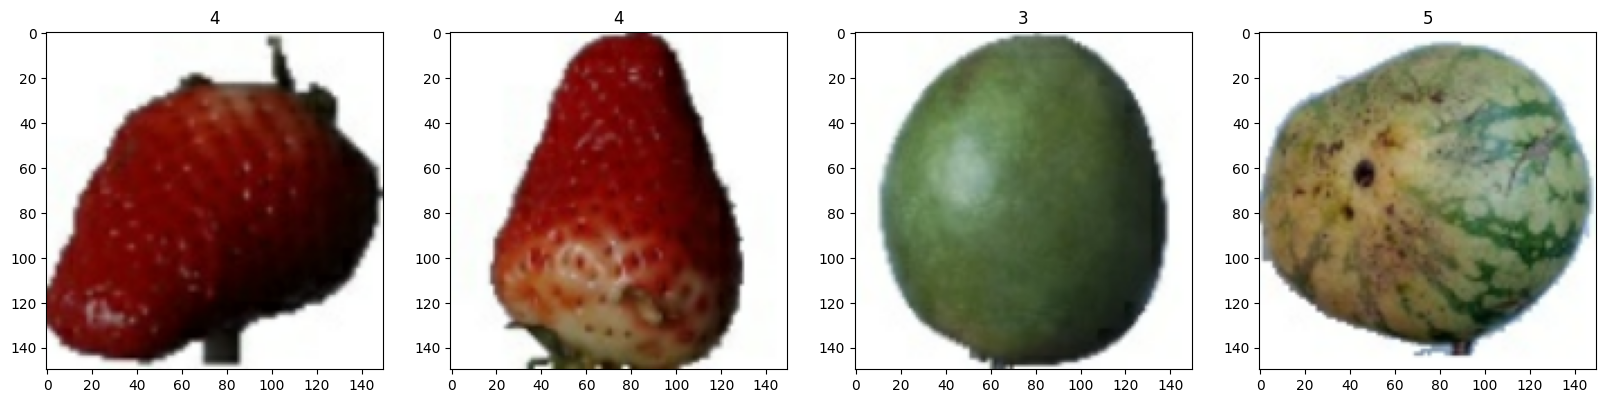

In [266]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype('uint8'))
    ax[idx].set_title(batch[1][idx])

In [267]:
scaled = batch[0] / 255.0

In [268]:
scaled.max()

1.0

# Preprocesamiento

In [269]:
data = data.map(lambda x, y: (x/255.0, y))

In [270]:
scaled_iterator = data.as_numpy_iterator()

2023-05-22 01:39:54.028676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2929]
	 [[{{node Placeholder/_0}}]]
2023-05-22 01:39:54.030607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2929]
	 [[{{node Placeholder/_4}}]]


In [271]:
batch = scaled_iterator.next()

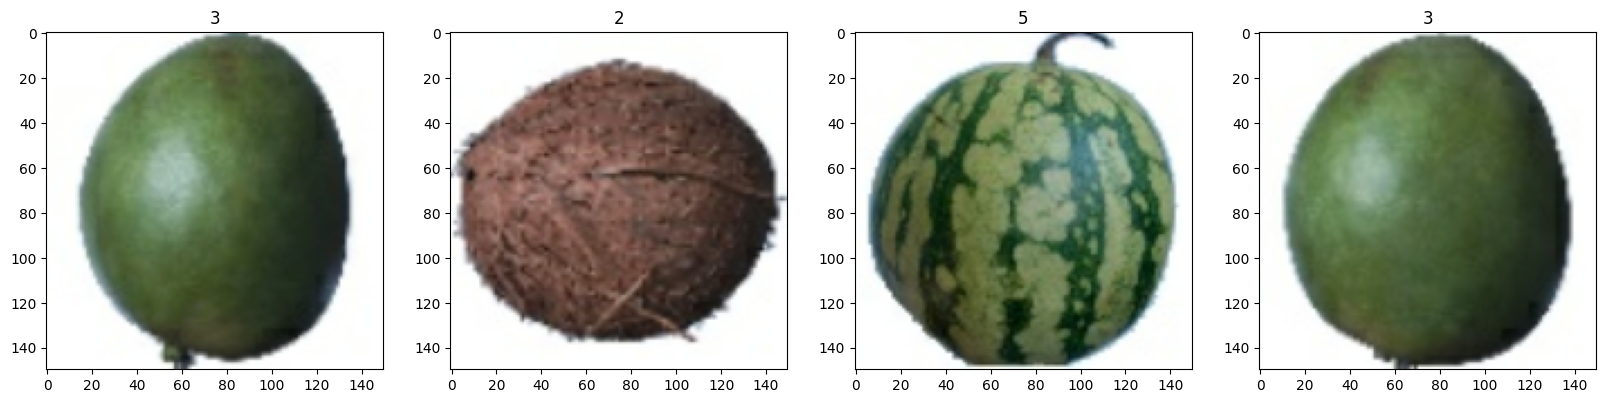

In [272]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

# Separación de los datos

In [273]:
len(data)

367

In [274]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [275]:
train_size+val_size+test_size

365

In [276]:
train = data.take(train_size)
test = data.skip(train_size)
val = test.skip(test_size)

# Modelado

In [291]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [292]:
model = Sequential()

In [293]:
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(150,150, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [294]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [295]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [296]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
256/256 [==============================] - 48s 176ms/step - loss: 0.1592 - accuracy: 0.9526 - val_loss: 2.0676e-04 - val_accuracy: 1.0000
Epoch 2/10
256/256 [==============================] - 56s 220ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 6.9943e-05 - val_accuracy: 1.0000
Epoch 3/10
256/256 [==============================] - 46s 179ms/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.0017 - val_accuracy: 0.9983
Epoch 4/10
256/256 [==============================] - 51s 197ms/step - loss: 2.3417e-05 - accuracy: 1.0000 - val_loss: 5.2213e-05 - val_accuracy: 1.0000
Epoch 5/10
256/256 [==============================] - 65s 252ms/step - loss: 7.3067e-06 - accuracy: 1.0000 - val_loss: 3.5650e-05 - val_accuracy: 1.0000
Epoch 6/10
256/256 [==============================] - 57s 222ms/step - loss: 4.3906e-06 - accuracy: 1.0000 - val_loss: 2.5314e-05 - val_accuracy: 1.0000
Epoch 7/10
256/256 [==============================] - 75s 293ms/step - loss: 2.9498e-06 - accuracy

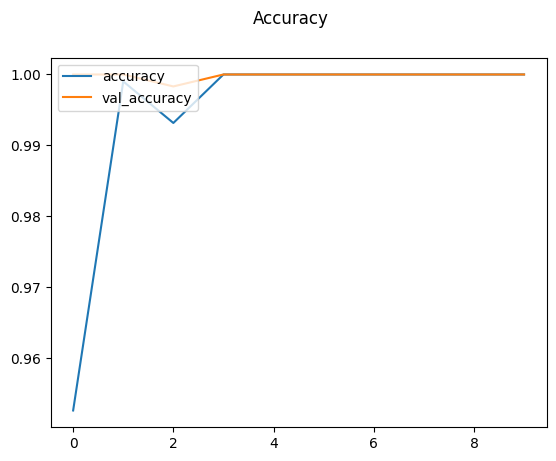

In [297]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.suptitle('Accuracy')
plt.legend(loc="upper left")
plt.show()

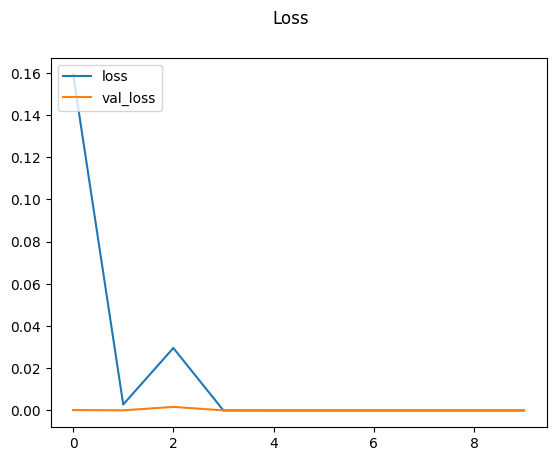

In [298]:
fig = plt.figure()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.suptitle('Loss')
plt.legend(loc="upper left")
plt.show()

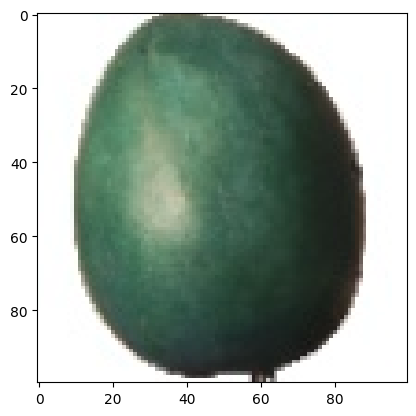

In [336]:
import cv2

img = cv2.imread('mtest.jpg')
plt.imshow(img)
plt.show()

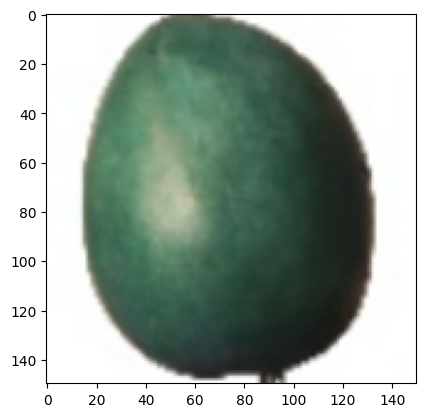

In [337]:
resize = tf.image.resize(img, (150,150))
plt.imshow(resize.numpy().astype('uint8'))
plt.show()

In [338]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 33ms/step


In [339]:
yhat

array([[3.2434993e-19, 2.0034520e-08, 6.8715111e-10, 1.0000000e+00,
        3.6402067e-10, 1.1448227e-08]], dtype=float32)

In [340]:
# dame el indice maximo
real_yhat = np.argmax(yhat)

In [341]:
if real_yhat == 0:
    print('apple')
elif real_yhat == 1:
    print('banana')
elif real_yhat == 2:
    print('kiwi')
elif real_yhat == 3:
    print('mango')
elif real_yhat == 4:
    print('orange')
elif real_yhat == 5:
    print('papaya')
elif real_yhat == 6:
    print('pepino')
elif real_yhat == 7:
    print('strawberry')
elif real_yhat == 8:
    print('watermelon')
else:
    print('unknown')

mango


In [342]:
model.save('fruits.h5')